# Classifiez automatiquement des biens de consommation

Vous êtes Data Scientist au sein de l’entreprise "**Place de marché**”, qui souhaite lancer une marketplace e-commerce.


Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible et dans l'optique d'un passage à l'échelle, **il devient nécessaire d'automatiser cette tâche**.

**Linda**, lead data scientist, vous demande donc d'étudier la faisabilité d'un **moteur de classification** des articles en différentes catégories, avec un niveau de précision suffisant.

## Les données
Linda vous a fourni un premier jeu de données d’articles avec le lien pour télécharger la photo et une description associée.

## Votre mission
Votre mission est de **réaliser une première étude de faisabilité d'un moteur de classification** d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.

Vous **analyserez le jeu de données** en **réalisant un prétraitement** des images et des descriptions des produits, une **réduction de dimension**, puis un **clustering**. Les résultats du clustering seront présentés sous la forme d’une représentation en deux dimensions à déterminer, qui ’illustrera le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

La représentation graphique vous aidera à convaincre Linda que cette approche de modélisation permettra bien de regrouper des produits de même catégorie.

Attention, Linda n’a pas besoin d’un moteur de classification à ce stade, mais bien d’une étude de faisabilité !

__Contraintes__
Linda vous a communiqué la contrainte suivante : afin d’extraire les features, mettre en œuvre a minima un algorithme de type SIFT / ORB / SURF.

Un algorithme de type CNN Transfer Learning peut éventuellement être utilisé en complément, s’il peut apporter un éclairage supplémentaire à la démonstration.

## Livrables attendus
Un **notebook** (ou des fichiers .py) contenant les fonctions permettant le prétraitement des données textes et images ainsi que les résultats du clustering (en y incluant des représentations graphiques au besoin).
Un support de **présentation** qui présente la démarche et les résultats du clustering.

**[I Chargement du dataset](#I-Chargement-du-dataset)**

**[II Tour d'horizon des variables](#II-Tour-d'horizon-des-variables)**

**[III Focus sur les variables images et product_description](#III-Focus-sur-les-variables-images-et-product_description)**\
[III.1 product_description](#III.1-product_description)

In [179]:
import pandas as pd
import missingno as msno
import skimage
from skimage import io
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# I Chargement du dataset

In [3]:
rootpath = "../data/Flipkart/"
data = pd.read_csv(rootpath+"flipkart_com-ecommerce_sample_1050.csv")
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

<AxesSubplot:>

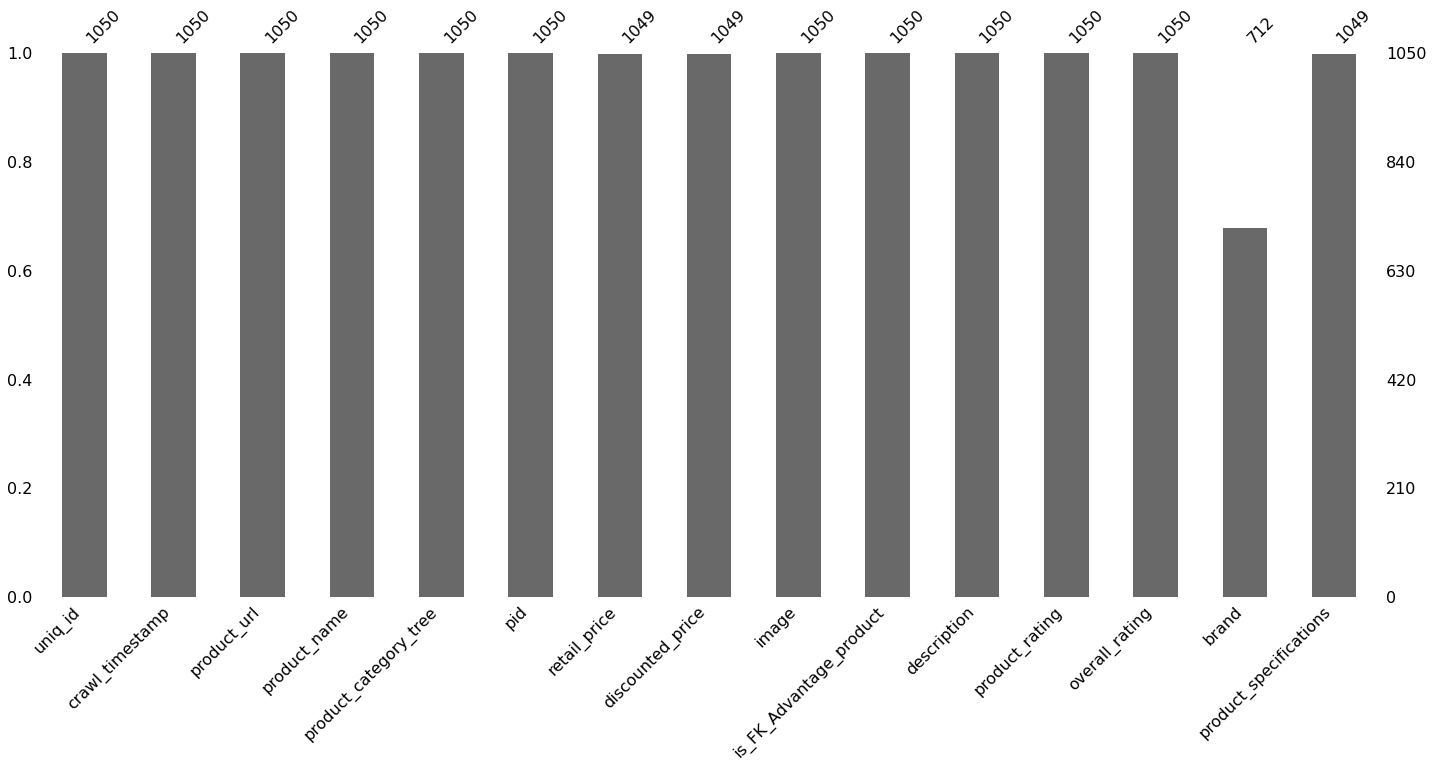

In [13]:
msno.bar(data)

# II Tour d'horizon des variables

## uniq_id

In [15]:
data.uniq_id.duplicated().sum()

0

In [16]:
data.uniq_id.isna().sum()

0

In [17]:
data.uniq_id.dtypes

dtype('O')

In [19]:
data.uniq_id.describe()

count                                 1050
unique                                1050
top       719677b02bfccafb86e9be78f36f938b
freq                                     1
Name: uniq_id, dtype: object

In [22]:
data.uniq_id.iloc[0]

'55b85ea15a1536d46b7190ad6fff8ce7'

## crawl_timestamp

In [23]:
data.crawl_timestamp

0       2016-04-30 03:22:56 +0000
1       2016-04-30 03:22:56 +0000
2       2016-04-30 03:22:56 +0000
3       2016-06-20 08:49:52 +0000
4       2016-06-20 08:49:52 +0000
                  ...            
1045    2015-12-01 10:15:43 +0000
1046    2015-12-01 10:15:43 +0000
1047    2015-12-01 10:15:43 +0000
1048    2015-12-01 10:15:43 +0000
1049    2015-12-01 10:15:43 +0000
Name: crawl_timestamp, Length: 1050, dtype: object

Il faut charger les données de cette colonne en type datetime

In [36]:
data.crawl_timestamp = pd.to_datetime(data.crawl_timestamp)
data.crawl_timestamp

0      2016-04-30 03:22:56+00:00
1      2016-04-30 03:22:56+00:00
2      2016-04-30 03:22:56+00:00
3      2016-06-20 08:49:52+00:00
4      2016-06-20 08:49:52+00:00
                  ...           
1045   2015-12-01 10:15:43+00:00
1046   2015-12-01 10:15:43+00:00
1047   2015-12-01 10:15:43+00:00
1048   2015-12-01 10:15:43+00:00
1049   2015-12-01 10:15:43+00:00
Name: crawl_timestamp, Length: 1050, dtype: datetime64[ns, UTC]

In [39]:
data.crawl_timestamp.describe(datetime_is_numeric=True)

count                                   1050
mean     2016-01-22 20:35:46.106679296+00:00
min                2015-12-01 06:13:00+00:00
25%                2015-12-01 12:40:44+00:00
50%                2016-01-01 10:55:30+00:00
75%         2016-03-03 10:08:31.500000+00:00
max                2016-06-26 14:21:24+00:00
Name: crawl_timestamp, dtype: object

<AxesSubplot:xlabel='crawl_timestamp', ylabel='Count'>

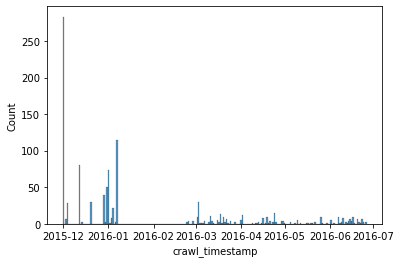

In [44]:
sns.histplot(data.crawl_timestamp.dt.date)

In [45]:
data.crawl_timestamp.isna().sum()

0

## Product url

In [46]:
data.product_url.iloc[0]

'http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z'

(http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z)

In [47]:
data.uniq_id.iloc[0]

'55b85ea15a1536d46b7190ad6fff8ce7'

## Product name

In [48]:
data.product_name.head()

0    Elegance Polyester Multicolor Abstract Eyelet ...
1                           Sathiyas Cotton Bath Towel
2                  Eurospa Cotton Terry Face Towel Set
3    SANTOSH ROYAL FASHION Cotton Printed King size...
4    Jaipur Print Cotton Floral King sized Double B...
Name: product_name, dtype: object

In [49]:
data.product_name.iloc[0]

'Elegance Polyester Multicolor Abstract Eyelet Door Curtain'

## Product category tree

In [50]:
data.product_category_tree.head()

0    ["Home Furnishing >> Curtains & Accessories >>...
1    ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2    ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
3    ["Home Furnishing >> Bed Linen >> Bedsheets >>...
4    ["Home Furnishing >> Bed Linen >> Bedsheets >>...
Name: product_category_tree, dtype: object

In [55]:
data.product_category_tree.iloc[0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

product_category_tree and product_name?

In [218]:
data.product_category_tree.apply(lambda x: x.replace(' >> ', '","'))

0       ["Home Furnishing","Curtains & Accessories","C...
1       ["Baby Care","Baby Bath & Skin","Baby Bath Tow...
2       ["Baby Care","Baby Bath & Skin","Baby Bath Tow...
3       ["Home Furnishing","Bed Linen","Bedsheets","SA...
4       ["Home Furnishing","Bed Linen","Bedsheets","Ja...
                              ...                        
1045    ["Baby Care","Baby & Kids Gifts","Stickers","O...
1046    ["Baby Care","Baby & Kids Gifts","Stickers","W...
1047    ["Baby Care","Baby & Kids Gifts","Stickers","U...
1048    ["Baby Care","Baby & Kids Gifts","Stickers","W...
1049    ["Baby Care","Baby & Kids Gifts","Stickers","U...
Name: product_category_tree, Length: 1050, dtype: object

In [217]:
data.product_name.iloc[1]

'Sathiyas Cotton Bath Towel'

In [219]:
data.product_category_tree.apply(lambda x: x.replace(' >> ', '","'))[0]

'["Home Furnishing","Curtains & Accessories","Curtains","Elegance Polyester Multicolor Abstract Eyelet Do..."]'

Il va falloir transformer ces chaînes de caractères en listes...

In [2]:
prod_cats = data.product_category_tree.apply(lambda x: x.replace(' >> ', '","'))
literal_eval(prod_cats[0])[0]

NameError: name 'data' is not defined

On y est!

On applique cette transformation à toutes les lignes de prod_cats

In [1]:
prod_cat_lists = []
for i in range(prod_cats.shape[0]):
    cat_list = literal_eval(prod_cats[i])
    prod_cat_lists.append(cat_list)
prod_cat_lists = pd.DataFrame(prod_cat_lists)
prod_cat_lists.head()

NameError: name 'prod_cats' is not defined

Il y a jusqu'à 6 catégories dans l'arbre des catégories de produit (product_category_tree). Combien de catégories uniques à chaque niveau?

In [224]:
prod_cat_lists.nunique()

0      7
1     62
2    241
3    349
4    297
5    117
6     57
dtype: int64

In [225]:
first_level_cat = set(prod_cat_lists[0].unique())
second_level_cat = set(prod_cat_lists[1].unique())

first_level_cat.intersection(second_level_cat)

set()

Les premières et deuxièmes catégories semblent ne pas être redondantes du tout (bonne nouvelle)

In [226]:
first_level_cat

{'Baby Care',
 'Beauty and Personal Care',
 'Computers',
 'Home Decor & Festive Needs',
 'Home Furnishing',
 'Kitchen & Dining',
 'Watches'}

In [227]:
second_level_cat

{'Baby & Kids Gifts',
 'Baby Bath & Skin',
 'Baby Bedding',
 'Baby Grooming',
 'Bar & Glassware',
 'Bath Linen',
 'Bath and Spa',
 'Beauty Accessories',
 'Bed Linen',
 'Body and Skin Care',
 'Candles & Fragrances',
 'Clocks',
 'Coffee Mugs',
 'Combos and Kits',
 'Computer Components',
 'Computer Peripherals',
 'Consumables & Disposables',
 'Containers & Bottles',
 'Cookware',
 'Curtains & Accessories',
 'Cushions, Pillows & Covers',
 'Decorative Lighting & Lamps',
 'Diapering & Potty Training',
 'Dinnerware & Crockery',
 'Eye Care',
 'Feeding & Nursing',
 'Floor Coverings',
 'Flowers, Plants & Vases',
 'Fragrances',
 'Furniture & Furnishings',
 'Garden & Leisure',
 'Hair Care',
 'Health Care',
 'Housekeeping & Laundry',
 'Infant Wear',
 'JMD Home Furnishing',
 'Kitchen & Dining Linen',
 'Kitchen Tools',
 "Kripa's Home Furnishing",
 'Laptop Accessories',
 'Laptops',
 'Lighting',
 'Living',
 'Living Room Furnishing',
 'Makeup',
 "Men's Grooming",
 'Network Components',
 'Pressure Cookers

La variable _product_tree_category_ va sans doute être utile.

Vu que le jeu de données contient cette variable de catégories de produits, il sera peut-être plus judicieux de réaliser une classification plutôt qu'un clustering à partir des descriptions (voir aussi les posts sur discord)

Suivant l'exploration qu'on vient de réaliser, on décide de se servir de la première valeur de _product_category_tree_ étiqueter chaque produit. On ajoute cette nouvelle variable au dataframe

In [228]:
# feature engineering
product_trees = (data.product_category_tree.apply(lambda x: x.replace(' >> ', '","'))
                 .apply(literal_eval)
                )

prod_cat_lists = []
for tree in product_trees:
    prod_cat_lists.append(tree[0])

data["product_category"] = prod_cat_lists
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,product_category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56+00:00,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56+00:00,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56+00:00,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52+00:00,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52+00:00,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing


## pid

In [58]:
data.pid.head()

0    CRNEG7BKMFFYHQ8Z
1    BTWEGFZHGBXPHZUH
2    BTWEG6SHXTDB2A2Y
3    BDSEJT9UQWHDUBH4
4    BDSEJTHNGWVGWWQU
Name: pid, dtype: object

pid and product_url?

In [62]:
(data.product_url.apply(lambda x: x.split('pid=')[-1]) == data.pid).sum()

1050

## retail price et discounted price

In [63]:
data.retail_price.head()

0    1899.0
1     600.0
2       NaN
3    2699.0
4    2599.0
Name: retail_price, dtype: float64

"image et description" --> le prix de vente n'est a priori pas utile pour ce projet. idem pour "discounted price"

In [64]:
data.discounted_price.head()

0     899.0
1     449.0
2       NaN
3    1299.0
4     698.0
Name: discounted_price, dtype: float64

## images

Le coeur du projet est le traitement et la classification d'images. Essayons d'afficher les images en utilisant le nom de fichier présent dans la table (les images se trouvent dans le dossier data/Flipkart/images/):

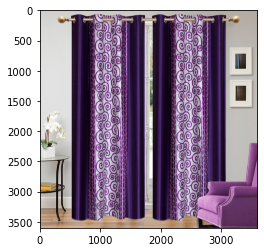

In [195]:
imdir = rootpath+"images/"

# on affiche seulement la première image pour l'exemple
filename = imdir + data.iloc[0]["image"]
image = skimage.io.imread(filename)
plt.imshow(image)

Ok pour les images.

On va maintenant inspecter les images à notre disposition. Sont-elles toutes là? Sont-elles en couleur ou en NB? Quelle(s) résolution(s) et définition(s)? 

In [172]:
list_images = ! ls ../data/Flipkart/images

In [174]:
len(list_images)

1050

On a bien 1050 fichiers.

On vérifie que la liste d'images provenant du dataset correspond bien aux fichiers du dossier

In [209]:
list_from_dataset = data.image
set(list_from_dataset) == set(list_images)

True

Ok

In [214]:
list_from_dataset.duplicated().sum()

0

On n'a pas de doublons.

In [177]:
list_png_files = [l for l in list_images if l.split('.')[-1]=='jpg']
len(list_png_files)

1050

**Affichage d'exemples d'images par label**

Beauty and Personal Care
-------


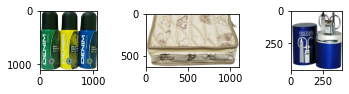

Watches
-------


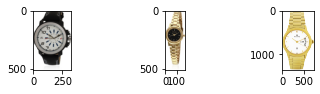

Computers
-------


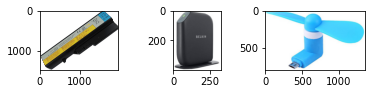

Home Decor & Festive Needs
-------


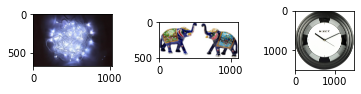

Home Furnishing
-------


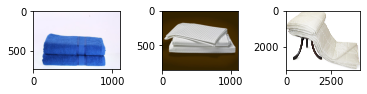

Baby Care
-------


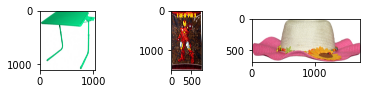

Kitchen & Dining
-------


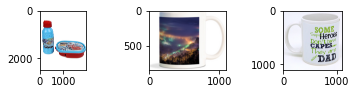

In [231]:
from matplotlib.image import imread

# chemin vers le dossier contenant les images
path_to_images = imdir

# liste des fichiers contenus dans le dataset (identique au contenu du dossier)
list_images = data.image.to_list()

# catégories en présence
list_cat = set(prod_cat_lists)

for cat in list_cat :
    print(cat)
    print("-------")
    fig = plt.figure(figsize=(7, 6))    
    images_from_cat = data.loc[data.product_category==cat, "image"].sample(3).to_list()
    for i in range(3):
        ax = fig.add_subplot(5,4,1 + i)
        filename = path_to_images + images_from_cat[i]
        image = imread(filename)
        plt.imshow(image)
    plt.tight_layout()
    plt.show()

Les labels utilisés ne sont pas forcément les plus adaptés pour une classification automatique: des objets semblables peuvent se trouver dans des catégories différentes, tandis que des objets très différents peuvent appartenir à la même catégorie. Il faudrait eventuellement voir en appliquant d'autres labels (les niveaux 2 et 6 dans l'arbre des catégories sont les niveaux présentant le moins de catégories parmi les niveaux restants).

Ces fichiers sont bien tous des .jpg. Inspectons maintenant les caracteristiques de ces fichiers à l'aide de la bibliothèque Pillow

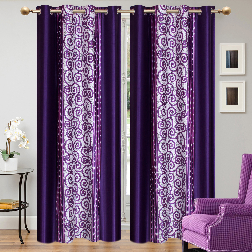

In [242]:
filename = path_to_images + list_images[0]
image1 = filename

# Charger l'image
img = Image.open(image1) 

# Afficher l'image chargée
new_size = tuple([int(0.07*s) for s in img.size])
img.resize(new_size)

In [243]:
# Récupérer et afficher la taille de l'image (en pixels)
w, h = img.size
print("Largeur : {} px, hauteur : {} px".format(w, h))

Largeur : 3600 px, hauteur : 3600 px


In [244]:
# Afficher son mode de quantification
print("Format des pixels : {}".format(img.mode))

# Récupérer et afficher la valeur du pixel à une position précise
px_value = img.getpixel((20,100))
print("Valeur du pixel situé en (20,100) : {}".format(px_value))

Format des pixels : RGB
Valeur du pixel situé en (20,100) : (211, 210, 206)


In [185]:
import numpy as np

# Récupérer les valeurs de tous les pixels sous forme d'une matrice
mat = np.array(img)

# Afficher la taille de la matrice de pixels
print("Taille de la matrice de pixels : {}".format(mat.shape))

Taille de la matrice de pixels : (3600, 3600, 3)


In [186]:
mat

array([[[192, 184, 173],
        [192, 184, 173],
        [193, 185, 174],
        ...,
        [174, 165, 156],
        [174, 165, 156],
        [174, 165, 156]],

       [[192, 184, 173],
        [193, 185, 174],
        [193, 185, 174],
        ...,
        [174, 165, 156],
        [174, 165, 156],
        [174, 165, 156]],

       [[192, 186, 174],
        [193, 187, 175],
        [193, 187, 175],
        ...,
        [175, 166, 157],
        [174, 165, 156],
        [174, 165, 156]],

       ...,

       [[209, 174, 136],
        [209, 174, 136],
        [209, 174, 136],
        ...,
        [130,  94,  96],
        [134,  99,  95],
        [139, 104,  98]],

       [[210, 175, 137],
        [210, 175, 137],
        [210, 175, 137],
        ...,
        [140, 105, 101],
        [143, 109, 100],
        [147, 113, 103]],

       [[210, 175, 137],
        [210, 175, 137],
        [210, 175, 137],
        ...,
        [149, 114, 108],
        [151, 117, 107],
        [154, 120, 108]]

On va répéter ce traitement sur toutes les images pour inspecter les différences entre caractéristiques de chaque image.

In [206]:
# récupération de la liste d'images avec leur chemin vers le dossier où elles sont déposées
images =  [imdir+l for l in list_images]

im_sizes = np.empty((1050,2))
im_modes = []
for i, img in enumerate(images):
    im = Image.open(img)
    im_sizes[i] = im.size
    im_modes.append(im.mode)
im_sizes

array([[ 687., 1162.],
       [1478.,  904.],
       [1347.,  326.],
       ...,
       [1100.,  935.],
       [1100.,  943.],
       [1100., 1077.]])

On a donc des tailles variables (largeur, hauteur)

In [205]:
np.unique(im_modes)

array(['RGB'], dtype='<U3')

Mais un seul "type" d'image.

# is_FK_Advantage_product

In [65]:
data.is_FK_Advantage_product.head()

0    False
1    False
2    False
3    False
4    False
Name: is_FK_Advantage_product, dtype: bool

<AxesSubplot:xlabel='is_FK_Advantage_product', ylabel='count'>

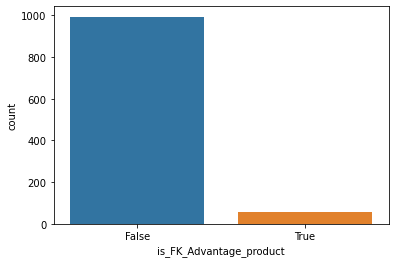

In [70]:
sns.countplot(x=data.is_FK_Advantage_product)

In [71]:
data[data.is_FK_Advantage_product==True]

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
114,bc784846bd59a16832454416ac708003,2016-01-03 09:39:44+00:00,http://www.flipkart.com/lollipop-lane-tiddly-w...,Lollipop Lane Tiddly Wink Safari Bath Set,"[""Baby Care >> Baby Grooming >> Baby Grooming ...",BBCDPFZM6V585ZZE,2950.0,2950.0,bc784846bd59a16832454416ac708003.jpg,True,Flipkart.com is offering Lollipop Lane Tiddly ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Age Group""..."
248,45d0af2c709de47268c80c35a117de44,2015-12-01 12:40:44+00:00,http://www.flipkart.com/malhar-niko-male-doll-...,Malhar Niko Male Doll Showpiece - 25 cm,"[""Home Decor & Festive Needs >> Showpieces >> ...",SHIEY382SR75SXEY,6395.0,5436.0,45d0af2c709de47268c80c35a117de44.jpg,True,Buy Malhar Niko Male Doll Showpiece - 25 cm ...,No rating available,No rating available,Malhar,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
310,64b463dc0b75ae40a848498c657041e6,2015-12-01 06:13:00+00:00,http://www.flipkart.com/linksys-smart-wi-fi-ro...,Linksys Smart Wi-Fi Router,"[""Computers >> Network Components >> Routers >...",RTRDZTF9DBT4CW8U,14999.0,13500.0,64b463dc0b75ae40a848498c657041e6.jpg,True,Buy Linksys Smart Wi-Fi Router only for Rs. 0....,No rating available,No rating available,Linksys,"{""product_specification""=>[{""key""=>""Encryption..."
324,a43fbae655e5d13215b9dd65339fa9d4,2015-12-01 06:13:00+00:00,http://www.flipkart.com/huawei-ws331c-300-mbps...,Huawei WS331c -300 Mbps Wireless Range Extender,"[""Computers >> Network Components >> Routers >...",RTREFWYNH9RGDCQK,2250.0,1635.0,a43fbae655e5d13215b9dd65339fa9d4.jpg,True,Buy Huawei WS331c -300 Mbps Wireless Range Ext...,3.5,3.5,Huawei,"{""product_specification""=>[{""key""=>""In The Box..."
336,6634de7b39a5b0658c74ab098450096d,2015-12-01 06:13:00+00:00,http://www.flipkart.com/d-link-dir-816-wireles...,D-Link DIR-816 Wireless AC750 Dual Band Router,"[""Computers >> Network Components >> Routers >...",RTRE3XW7JS6YJHG5,4200.0,2059.0,6634de7b39a5b0658c74ab098450096d.jpg,True,Buy D-Link DIR-816 Wireless AC750 Dual Band Ro...,4,4,D-Link,"{""product_specification""=>[{""key""=>""Other Secu..."
341,fce2bd96b35d531a4784bc57e19aca4f,2015-12-01 06:13:00+00:00,http://www.flipkart.com/belkin-share-modem-n-r...,Belkin Share Modem (N) Router,"[""Computers >> Network Components >> Routers >...",RTRDFFYGM2TEWVCC,6249.0,6249.0,fce2bd96b35d531a4784bc57e19aca4f.jpg,True,Buy Belkin Share Modem (N) Router only for Rs....,3.7,3.7,Belkin,"{""product_specification""=>[{""key""=>""Firewall"",..."
343,9743e6d1c9f3180483825fe4d2e97836,2015-12-01 06:13:00+00:00,http://www.flipkart.com/apple-airport-express-...,Apple AirPort Express Base Station Wireless Ro...,"[""Computers >> Network Components >> Routers >...",RTRDQSSHGP7UGRFC,6800.0,6399.0,9743e6d1c9f3180483825fe4d2e97836.jpg,True,Buy Apple AirPort Express Base Station Wireles...,4.9,4.9,Apple,"{""product_specification""=>[{""key""=>""Firewall"",..."
367,884ff6050ff3d6b2c8f681c300a21b2a,2015-12-01 06:13:00+00:00,http://www.flipkart.com/tp-link-archer-c20-ac7...,TP-Link Archer C20 AC750 Dual Band Router,"[""Computers >> Network Components >> Routers >...",RTRE8GKF2CUJ2GNN,5399.0,2150.0,884ff6050ff3d6b2c8f681c300a21b2a.jpg,True,Buy TP-Link Archer C20 AC750 Dual Band Router ...,4.4,4.4,TP-LINK,"{""product_specification""=>[{""key""=>""Firewall"",..."
371,2a20862f02555a44b0ab301bed987a0b,2015-12-01 06:13:00+00:00,http://www.flipkart.com/netgear-jwnr2010-n300-...,Netgear JWNR2010 N300 Wireless Router,"[""Computers >> Network Components >> Routers >...",RTRDPXKCBHEECZQE,2500.0,1367.0,2a20862f02555a44b0ab301bed987a0b.jpg,True,Buy Netgear JWNR2010 N300 Wireless Router only...,3.9,3.9,Netgear,"{""product_specification""=>[{""key""=>""Firewall"",..."
390,ae19a81b730b48b87ca72521af8fb902,2015-12-01 06:13:00+00:00,http://www.flipkart

## description

L'autre variable au coeur de ce projet.

In [72]:
data.description.head()

0    Key Features of Elegance Polyester Multicolor ...
1    Specifications of Sathiyas Cotton Bath Towel (...
2    Key Features of Eurospa Cotton Terry Face Towe...
3    Key Features of SANTOSH ROYAL FASHION Cotton P...
4    Key Features of Jaipur Print Cotton Floral Kin...
Name: description, dtype: object

In [73]:
data.description.iloc[0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [74]:
data.product_url.iloc[0]

'http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z'

## brand

In [75]:
data.brand.head()

0                 Elegance
1                 Sathiyas
2                  Eurospa
3    SANTOSH ROYAL FASHION
4             Jaipur Print
Name: brand, dtype: object

## product specifications

In [76]:
data.product_specifications.head()

0    {"product_specification"=>[{"key"=>"Brand", "v...
1    {"product_specification"=>[{"key"=>"Machine Wa...
2    {"product_specification"=>[{"key"=>"Material",...
3    {"product_specification"=>[{"key"=>"Brand", "v...
4    {"product_specification"=>[{"key"=>"Machine Wa...
Name: product_specifications, dtype: object

In [77]:
data.product_specifications.iloc[0]

'{"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value"=>"Door"}, {"key"=>"Type", "value"=>"Eyelet"}, {"key"=>"Model Name", "value"=>"Abstract Polyester Door Curtain Set Of 2"}, {"key"=>"Model ID", "value"=>"Duster25"}, {"key"=>"Color", "value"=>"Multicolor"}, {"key"=>"Length", "value"=>"213 cm"}, {"key"=>"Number of Contents in Sales Package", "value"=>"Pack of 2"}, {"key"=>"Sales Package", "value"=>"2 Curtains"}, {"key"=>"Material", "value"=>"Polyester"}]}'

In [88]:
literal_eval(data.loc[data.product_specifications.notna(), "product_specifications"].apply(lambda x: x.replace("=>", ":")).iloc[0])

{'product_specification': [{'key': 'Brand', 'value': 'Elegance'},
  {'key': 'Designed For', 'value': 'Door'},
  {'key': 'Type', 'value': 'Eyelet'},
  {'key': 'Model Name', 'value': 'Abstract Polyester Door Curtain Set Of 2'},
  {'key': 'Model ID', 'value': 'Duster25'},
  {'key': 'Color', 'value': 'Multicolor'},
  {'key': 'Length', 'value': '213 cm'},
  {'key': 'Number of Contents in Sales Package', 'value': 'Pack of 2'},
  {'key': 'Sales Package', 'value': '2 Curtains'},
  {'key': 'Material', 'value': 'Polyester'}]}

In [100]:
from ast import literal_eval # module pour évaluer une expression et renvoyer l'objet correspondant
X = data[data.product_specifications.notna()].copy()
X["product_specifications"] = (X["product_specifications"]
                               .apply(lambda x: x.replace("=>", ":"))
                              )

try:
    X.product_specifications.apply(literal_eval)
except:
    pass


df = pd.json_normalize(X["product_specifications"]) # Normalize semi-structured JSON data into a flat table.
df.head()

AttributeError: 'str' object has no attribute 'values'

Il faudra envisager un traitement un peu plus spécifique si cette colonne est utile.

# III Focus sur les variables images et product_description

## III.1 product_description 

### I. Création du corpus

### II. Tokenization

### III. Nettoyage des stopwords

### IV. Lemmatization

### V. Création des bag-of-words

### VI. Regroupement par topics: LDA

### VII. Plongement de mots et classification par RNN

## III.2 images

### 0. Caractéristiques des images - exploration du dataset

### I. Redimensionnement

### II. conversion n&b

### III. égalisation de l'histogramme

### IV. Création de multiples "transformés" (rotation, déformation etc.) ?